In [1]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm_notebook as tqdm
# from tqdm import tqdm
import gym_agent as ga

In [2]:
total_timesteps = 200000
max_episode_steps = 500
chkpt_dir = "checkpoints/"

env_id = 'LunarLander-v3'

# DQN

In [3]:
class DeepQNetwork(nn.Module):
    def __init__(self, n_inp: int, n_out: int, features: list[int] = [64, 64]):
        super().__init__()

        layers = [n_inp] + features + [n_out]

        self.net = nn.Sequential()

        for i in range(len(layers)-1):
            self.net.append(nn.Linear(layers[i], layers[i+1]))

            if i < len(layers)-2:
                self.net.append(nn.ReLU())

    def forward(self, X):
        return self.net(X)

In [4]:
def net_factory():
    return DeepQNetwork(
        n_inp=8,
        n_out=4,
        features=[256, 256]
    )

In [5]:
policy = ga.core.TargetPolicy(
    net_factory_func=net_factory,
    lr = 1e-3
)

In [6]:
agent = ga.DQN(
    env_id=env_id,
    policy=policy,
    config=ga.DQNConfig(
        eps_decay_steps=100000,
        env_kwargs={"max_episode_steps": max_episode_steps},
    )
)

/Users/thefool/Local/Project/MATE/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


/Users/thefool/Local/Project/MATE/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [7]:
agent.fit(total_timesteps=total_timesteps, save_best=True, save_dir=chkpt_dir, progress_bar=tqdm)

/Users/thefool/Local/Project/MATE/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


  0%|          | 0/200000 [00:00<?, ?it/s]

In [7]:
agent = ga.DQN.from_checkpoint(policy, chkpt_dir, env_id, "DQN", "last")

/Users/thefool/Local/Project/MATE/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


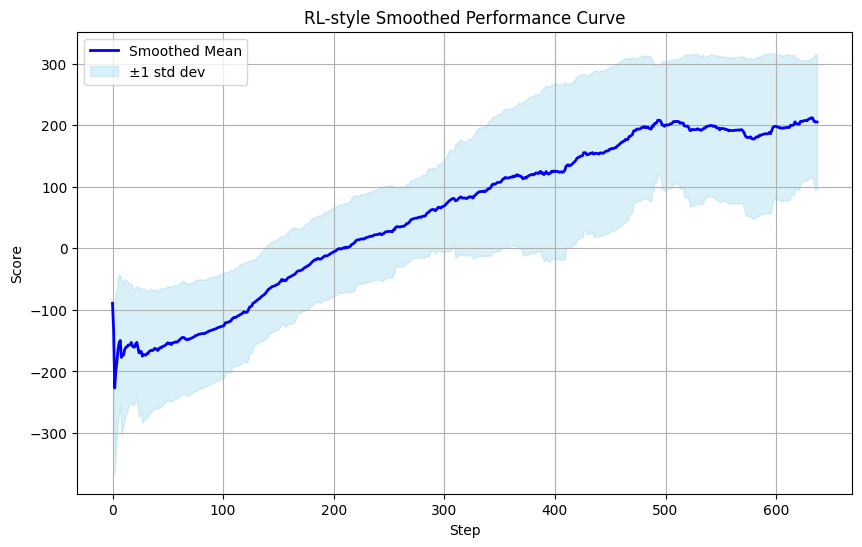

In [9]:
agent.plot_scores()

# A2C/PPO

In [10]:
class Feature_Extractor(nn.Module):
    def __init__(self, n_inp: int, features: list[int] = [256, 256]):
        super().__init__()

        layers = [n_inp] + features

        self.net = nn.Sequential()

        for i in range(len(layers)-1):
            self.net.append(nn.Linear(layers[i], layers[i+1]))
            self.net.append(nn.ReLU())

    def forward(self, X):
        return self.net(X)

In [11]:
def feature_extractor_factory():
    return Feature_Extractor(
        n_inp=8,
        features=[256, 256]
    )

def actor_factory():
    net = nn.Sequential(
        Feature_Extractor(n_inp=8, features=[256, 256]),
        nn.Linear(256, 4)
    )
    return net

def critic_factory():
    net = nn.Sequential(
        Feature_Extractor(n_inp=8, features=[256, 256]),
        nn.Linear(256, 1)
    )
    return net

In [13]:
agent = ga.A2C(
    env_id=env_id,
    policy=ga.core.ActorCriticPolicy(
        actor_factory_func=actor_factory,
        critic_factory_func=critic_factory,
        actor_lr=7e-4,
        optim_cls=torch.optim.RMSprop,
        optim_kwargs={"alpha": 0.99, "eps": 1e-5, "weight_decay": 0.0},
    ),
    config=ga.A2CConfig(
        num_envs=4,
        n_steps=8,
        entropy_coef=0.01,
        normalize_advantage=False,
        env_kwargs={"max_episode_steps": max_episode_steps},
    )
)

/Users/thefool/Local/Project/MATE/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
/Users/thefool/Local/Project/MATE/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
/Users/thefool/Local/Project/MATE/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_

In [14]:
agent.fit(total_timesteps=total_timesteps, save_best=True, save_dir=chkpt_dir, progress_bar=tqdm)

  0%|          | 0/200000 [00:00<?, ?it/s]

In [16]:
agent = ga.A2C.from_checkpoint(agent.policy, chkpt_dir, env_id, "A2C", "last")

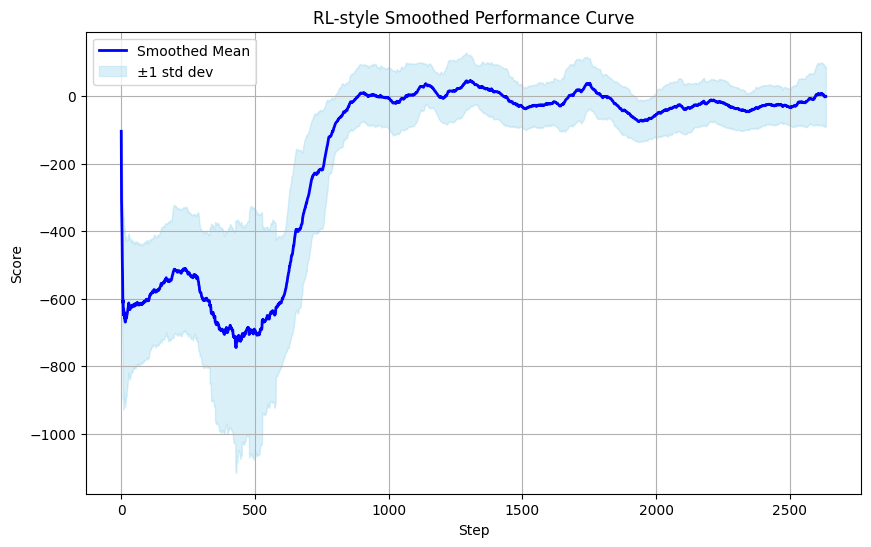

In [17]:
agent.plot_scores()

In [19]:
agent = ga.PPO(
    env_id=env_id,
    policy=ga.core.ActorCriticPolicy(
        actor_factory_func=actor_factory,
        critic_factory_func=critic_factory,
        actor_lr=3e-4,
    ),
    config=ga.PPOConfig(
        # num_envs=8,
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        clip_range=0.2,
        entropy_coef=0.01,
        gae_lambda=0.95,
        gamma=0.99,
        normalize_advantage=True,
        env_kwargs={"max_episode_steps": max_episode_steps},
    )
)

/Users/thefool/Local/Project/MATE/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [20]:
agent.fit(total_timesteps=total_timesteps, save_best=True, save_dir=chkpt_dir, progress_bar=tqdm)

  0%|          | 0/200000 [00:00<?, ?it/s]

In [25]:
agent = ga.PPO.from_checkpoint(agent.policy, chkpt_dir, env_id, "PPO", "last")

/Users/thefool/Local/Project/MATE/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


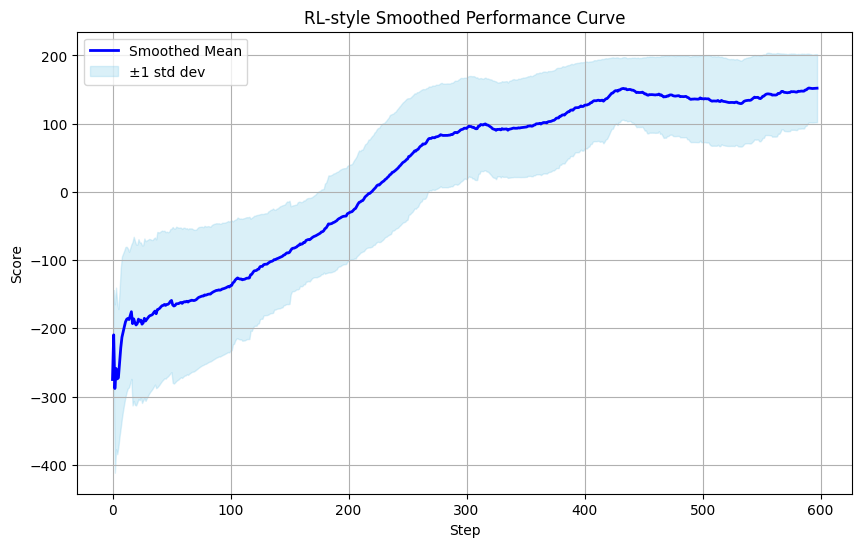

In [26]:
agent.plot_scores()